# Eigenfaces

This guide will go through the classic ['Eigenfaces'](https://en.wikipedia.org/wiki/Eigenface) procedure in computer vision and machine learning. The guide should serve as a good introduction to [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) and [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis). Besides for being extremely important for machine learning, dimensionality reduction will give us some insights into the properties of data distributions, and are a first step towards understanding [generative models](https://en.wikipedia.org/wiki/Generative_model) such as [autoencoders](https://en.wikipedia.org/wiki/Autoencoder) and [generative adversarial networks](https://arxiv.org/abs/1511.06434) more generally.

To go through this guide, you need to install:

 * [scikit-learn](scikit-learn.org)
 * [tqdm](https://pypi.python.org/pypi/tqdm)
 * [Pillow](https://python-pillow.org/)
 * [matplotlib](http://matplotlib.org)
 * [scipy](https://www.scipy.org/) (just for saving images to disk)

You also need to download and unzip the 'labeled faces in the wild' dataset which can be downloaded from:

 * [http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz)
 
Run the first cell to verify all the libraries and load all of the images in LFW into memory.

In [1]:
%matplotlib inline

import fnmatch
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
from sklearn.decomposition import PCA

lfw_path = "../data/lfw_funneled"

images = []
for root, dirnames, filenames in os.walk(lfw_path):
    for filename in fnmatch.filter(filenames, '*.jpg'):
        images.append(os.path.join(root, filename))

n = len(images)
print("loaded %d face images" % n)

loaded 13233 face images


Let's have a look at a random selection of faces in LFW.

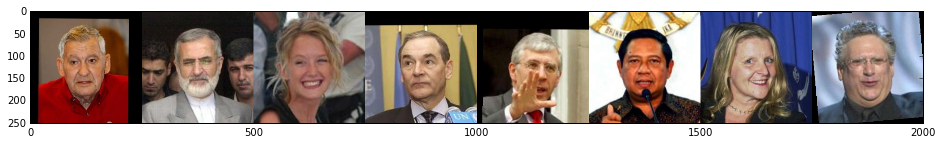

In [64]:
img = [Image.open(images[int(n*random.random())]) for i in range(8)]
img = np.concatenate([np.array(im.getdata()).reshape((im.size[0], im.size[1], 3)) for im in img ], axis=1)
plt.figure(figsize=(16,2))
plt.imshow(Image.fromarray(img.astype('uint8')))

Let's resize all the images to `100*100` and put them into a `n*d` matrix, where the `n` rows correspond to our `n` face images of size `d=100*100=10000`.

In [2]:
w = h = 100

X = np.zeros((n, w*h*3))
for i, img in tqdm(enumerate(images)):
    im = Image.open(img)
    im = im.resize((w, h))#.convert('L')
    pixels = list(im.getdata())
    X[i, :] = np.array(pixels).flatten()

13233it [02:01, 108.58it/s]


Now that we have our data matrix, let's apply principal component analysis to it, and keep the first `n_components = 100` principal components. PCA maps the original points into a smaller subspace by transforming them into a space whose basis vectors are the principal components of the original data which capture the most variance within the data. This gives us a much smaller representation of the original data, but preserves most of the information. 

In [57]:
n_components = 100
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=True)

After calculating the principal components, we use them to project the original data points `X` into a `n_components`-dimensional space.

In [58]:
Xp = pca.transform(X)
print(Xp)

[[-1.39376448  1.77431855 -0.23445537 ..., -0.23259235 -0.6539918
  -0.51443786]
 [-0.5013077   0.13749541  0.57190141 ...,  0.4070994   1.32250525
  -1.93511831]
 [ 0.35573575  0.83974058 -1.15423884 ...,  0.79919035  0.35585357
  -0.73351072]
 ..., 
 [-0.80020942 -0.51187989 -1.34662922 ...,  0.12353436 -0.88381107
  -1.03773631]
 [-1.31239152 -0.22458005  0.80998349 ...,  0.41955168  0.22045244
   0.46440413]
 [-1.40931463  1.33759458 -0.28731356 ...,  0.43884686  0.03718062
   0.0555222 ]]


The rows of `Xp` can be interpreted as compressed representations of the rows of `X`. Two vectors which are similar in `X` (i.e. have a small distance between them) should be similar in `Xp` as well.

PCA works (usually) using a [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of the data matrix. This is a matrix factorization in which the principal component vectors are ordered by decreasing variance. A dimensionality reduction is achieved simply by removing all but the first `n_components` components. Thus the resulting `Xp` is an `n * num_components` matrix.

Because PCA comes from a matrix factorization, we can simply invert it to reproject the new points back into the original pixel space. This gives us a new matrix, `Xt` which is the reconstruction of `X` from the principal components.

In [59]:
Xt = pca.inverse_transform(Xp)
Xt = np.clip(Xt, 0, 255)

But remember! We have discarded some of the information when we projected the original points into PCA space. Thus the reconstruction is not perfect, it is lossy. How lossy is it?  We can see this by projecting the PCA points of several faces back into pixel space, and comparing their reconstructions against the original images.

The following cell picks a random selection of 8 faces from LFW, and compares the original (resized to 100x100) pixels against the ones reconstructed from the PCA.

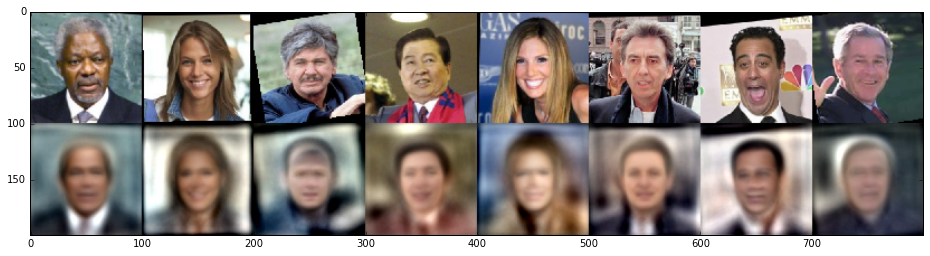

In [69]:
img_pairs = [[X[idx].reshape((w,h,3)), Xt[idx].reshape((w,h,3))] for idx in np.random.randint(n, size=8)]
img_all = np.concatenate([ np.concatenate([p[0], p[1]]) for p in img_pairs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(Image.fromarray(img_all.astype('uint8')))

As you can see the reconstructions give the impression of the originals, but look like they have lost a lot of the  information. Nevertheless, it should seem impressive that we've been able to reconstruct something which resembles the original image, given that the reconstruction came from just a code of 100 numbers. The original images were represented by 100 * 100 * 3 = 30,0000 numbers. That's a huge compression!

Here's another idea. What if instead of reprojecting the PCA-projected points from the original data... we just tried to project random numbers back into pixel space! 

The following bit of code will create 8 random codes (equivalent to our points in PCA space) which are sampled from a unit normal distribution. It will then project those codes into pixel space using our inverted principal component analysis.

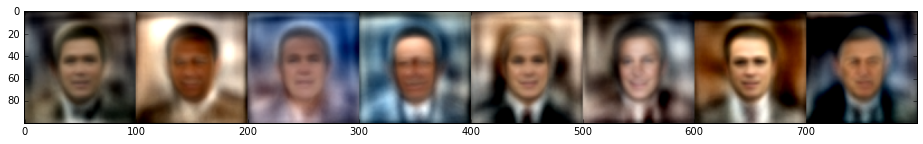

In [61]:
Y = [ np.random.normal(size=n_components) for i in range(8) ] 
Yt = [ np.clip(pca.inverse_transform(y), 0, 255) for y in Y ]
Yt = np.concatenate([ yt.reshape((w,h,3)) for yt in Yt ], axis=1)
plt.figure(figsize=(16,2))
plt.imshow(Image.fromarray(Yt.astype('uint8')))

Remarkably, a random vector projected through our PCA vectors creates what appears to be a face! And quite a variety of them! The reconstruction is not perfect -- it's quite blurry...  But cool that a little bit of dust can magically create something we recognize.

Here's another technique.  What if we take two random faces from our dataset, and project a series of vectors which are taken by interpolating between the PCA vectors of those two faces? The following cell will generate four series of those (with 8 interpolations in between).

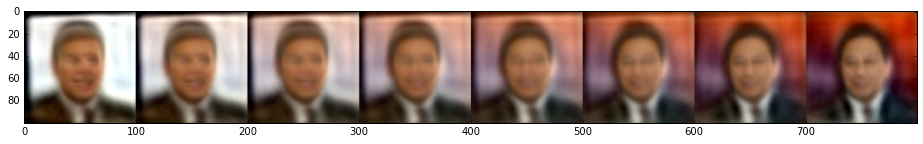

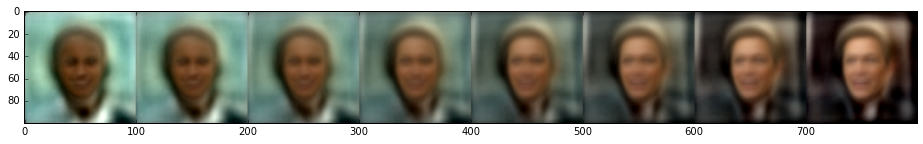

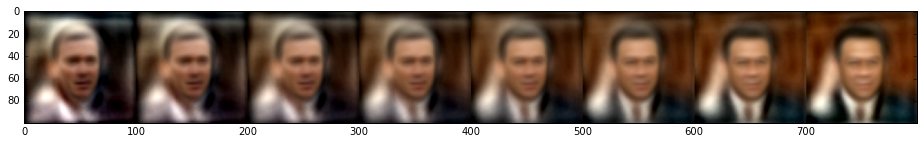

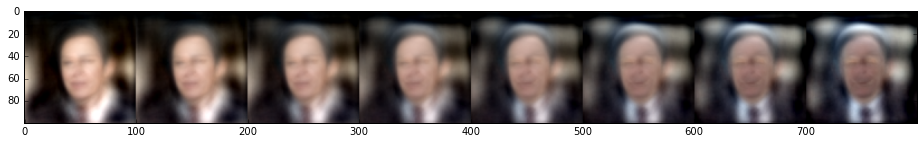

In [73]:
for i in range(4):
    xp1, xp2 = Xp[int(n*random.random())], Xp[int(n*random.random())]
    Z = [[(1.0-r)*i1 + r*i2 for i1, i2 in zip(xp1, xp2)] for r in np.linspace(0,1,8)]
    Y = np.concatenate([ np.clip(pca.inverse_transform(z), 0, 255).reshape((w,h,3)) for z in Z ], axis=1)
    plt.figure(figsize=(16,2))
    plt.imshow(Image.fromarray(Y.astype('uint8')))

Another useful thing for us would be to see how good the reconstructions are depending on the number of principal components we keep. The following block of code will do PCAs of 2000, 1000, 500, 100, 50, 10, 2, and 1 component respectively. We'll store those in an array to generate samples from in the next cell.

Note: the following block of code is probably implemented inefficiently. It should be possible to do the analysis once and then make copies of it, storing a different number of principal components with each, but I didn't see how to do that through scikit-learn's API, so at the moment it's just recomputing PCA each time.

In [15]:
npca = [2000, 1000, 500, 100, 50, 10, 2, 1]
Xt = []
for p in npca:
    print("computing PCA for %d components"%p)
    pca = PCA(n_components=p, svd_solver='randomized', whiten=True)
    pca.fit(X)
    Xp = pca.transform(X)
    Xt.append(np.clip(pca.inverse_transform(Xp), 0, 255))

computing PCA for 2000 components
computing PCA for 1000 components
computing PCA for 500 components
computing PCA for 100 components
computing PCA for 50 components
computing PCA for 10 components
computing PCA for 2 components
computing PCA for 1 components


Having finished the above analysis, we will now pick four faces at random, and show the reconstruction of the reduced representation back into pixel space, for each of the number of components we calculated above, starting with 2000 and going down to 1.

A few interesting things stand out:

- reconstructions from 2000 components look fairly similar to the originals, and 1000 looks like a poorly compressed JPG. Considering the originals are encoded as `100 * 100 * 3 = 30,000` numbers (>>1000), that's pretty decent for such a large reduction.
- down to perhaps 50 or so components, we are still able to capture nuances of the original image such as clothing color and background. After that we progressively lose more and more non-essential or uncommon nuances.
- At < 10 components, only the bare essentials of average human faces can be preserved.
- At just one component, every face looks almost exactly the same, which is roughly the average face found in the dataset. The distribution of our dataset seems to contain many short-haired, front-facing, middle-aged white men wearing suits and ties. Every sample in our dataset eventually converges to this.
- It is impressive, however, that encoding every single image with just one principal component (meaning a code of just _a single number_!) is able to reconstruct something that looks like a face at all.  

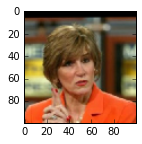

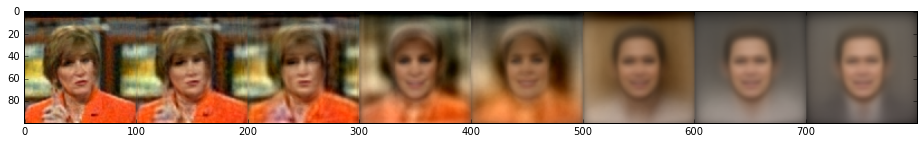

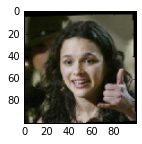

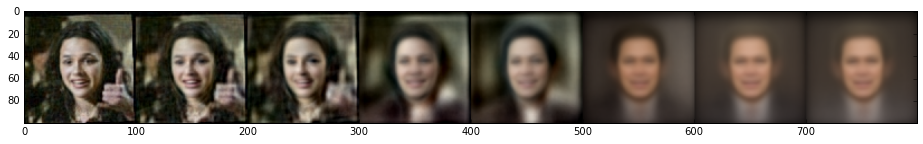

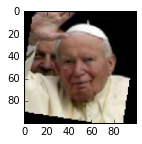

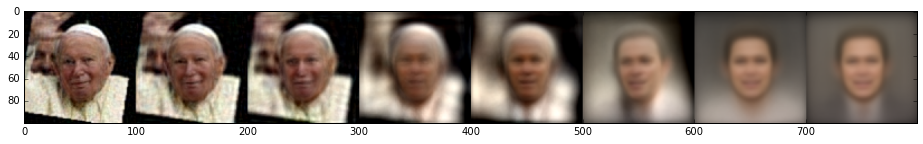

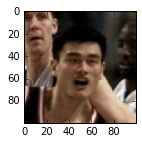

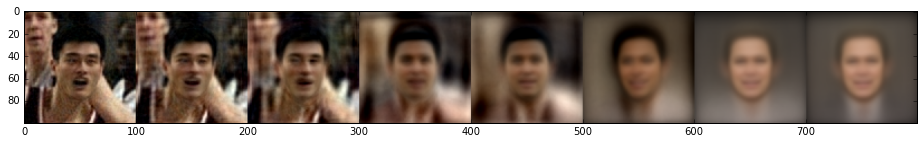

In [31]:
idxs = np.random.randint(n, size=4)
for i,idx in enumerate(idxs):
    img_orig = X[idx].reshape((w,h,3))
    img_reconstructed = np.concatenate([Xt[p][idx].reshape((w,h,3)) for p in range(len(npca))], axis=1)
    plt.figure(figsize=(2,2))
    plt.imshow(Image.fromarray(img_orig.astype('uint8')))
    plt.figure(figsize=(16,2))
    plt.imshow(Image.fromarray(img_reconstructed.astype('uint8')))

The below code will generate the frames for a movie which has a grid of faces going through interpolations using the technique above. The code is messy but should work.

In [77]:
import scipy.misc
import os

cols, rows = 10, 4
nf = 24  # num frames per transitions
ni = 4   # num transitions

folder='temp'
os.makedirs(folder)
os.makedirs('%s/composite'%folder)
print("generating frames for individual faces")
for i in tqdm(range(cols)):
    for j in range(rows):
        idx = np.random.randint(n, size=ni)
        idx = np.append(idx, idx[0])
        f = 1
        for k in range(ni):
            xp1, xp2 = Xp[idx[k]], Xp[idx[k+1]]
            Z = [[(1.0-r)*i1 + r*i2 for i1, i2 in zip(xp1, xp2)] for r in np.linspace(0,1,nf)]
            Y = [ np.clip(pca.inverse_transform(z),0,255).reshape((w,h,3)) for z in Z ]
            for y in Y:
                scipy.misc.imsave('%s/face%02d_%02d_frame%04d.png'%(folder,i,j,f), y.astype('uint8'))
                f+=1
offset = np.random.randint(nf*(ni-1), size=cols*rows)
print("compositing all the faces into one video")
for f in tqdm(range(nf*ni)):
    img = Image.new('RGB',(w * cols, h * rows))
    for i in range(cols):
        for j in range(rows):
            fidx = 1+(f + offset[i*rows+j])%(nf*ni)
            im = Image.open('%s/face%02d_%02d_frame%04d.png'%(folder,i,j,fidx))
            img.paste(im, (i*w, j*h))
    img = img.resize((int(1.2*img.size[0]), int(1.2*img.size[1]))) #upscale just a bit
    scipy.misc.imsave('temp/composite/frame%04d.png'%f, img)
cmd = "ffmpeg -i %s/composite/frame%%04d.png -c:v libx264 -pix_fmt yuv420p composite.mp4"%folder
print(cmd)
os.system(cmd)
os.system("rm -rf %s"%folder)
print("done!")

  0%|          | 0/10 [00:00<?, ?it/s]

generating frames for individual faces


  0%|          | 0/96 [00:00<?, ?it/s]

compositing all the faces into one video


100%|██████████| 96/96 [00:43<00:00,  2.20it/s]


ffmpeg -i temp/composite/frame%04d.png -c:v libx264 -pix_fmt yuv420p composite.mp4
done!


The above will generate an mp4 of a grid of face interpolations, like the following:

![eigenface_grid_4x4](../assets/eigenface_grid_4x4.gif)

In general, we see that PCA is a powerful tool for dimensionality reduction, and the value of dimensionality reduction for modeling data distributions. By capturing the a data distribution's most salient high-level features, we are able to randomly pull out realistic-looking samples. But as we shall see (in a future guide), we can do much better for generative mdoels by using nonlinear methods like variational autoencoders or generative adversarial networks instead. 